# Clasificación de Imágenes con XGBoost
Este notebook clasifica imágenes en 4 categorías: benign, early, pre, y pro usando XGBoost

In [1]:
# Importar librerías necesarias
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm

In [2]:
# Configuración
DATASET_PATH = 'dataset'
IMG_SIZE = (124, 124)  # Redimensionar imágenes para reducir dimensionalidad
CLASSES = ['kidney_normal', 'kidney_tumor']
RANDOM_STATE = 42

In [3]:
# Función para cargar y preprocesar imágenes
def load_images(dataset_path, classes, img_size):
    X = []
    y = []
    
    for class_idx, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        print(f"Cargando clase: {class_name}")
        
        images = os.listdir(class_path)
        
        for img_name in tqdm(images):
            try:
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img, dtype=np.float32) / 255.0  # Escalar directamente
                img_array = img_array.flatten()  # Convertir a vector 1D
                X.append(img_array)
                y.append(class_idx)
            except Exception as e:
                print(f"Error cargando {img_path}: {e}")
    
    return np.array(X, dtype=np.float32), np.array(y)

In [4]:
# Cargar imágenes
print("Iniciando carga de imágenes...")
X, y = load_images(DATASET_PATH, CLASSES, IMG_SIZE)
# print(f"\nDatos cargados: {X.shape[0]} imágenes")
# print(f"Dimensión de características: {X.shape[1]}")
# print(f"Distribución de clases: {np.bincount(y)}")

Iniciando carga de imágenes...
Cargando clase: kidney_normal


100%|██████████| 6000/6000 [00:19<00:00, 309.36it/s]


Cargando clase: kidney_tumor


100%|██████████| 6000/6000 [00:19<00:00, 314.53it/s]


In [5]:
# Dividir dataset en entrenamiento (60%), validación (20%) y prueba (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_val
)

# print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
# print(f"Conjunto de validación: {X_val.shape[0]} muestras")
# print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

In [6]:
# Crear matrices DMatrix para XGBoost (optimización de rendimiento)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [7]:
# Configurar parámetros de XGBoost
params = {
    'objective': 'multi:softprob',  # Para clasificación multiclase con probabilidades
    'num_class': len(CLASSES),       # Número de clases
    'max_depth': 6,                  # Profundidad máxima de los árboles
    'learning_rate': 0.1,            # Tasa de aprendizaje (eta)
    'subsample': 0.8,                # Fracción de muestras para entrenar cada árbol
    'colsample_bytree': 0.8,         # Fracción de características para cada árbol
    'min_child_weight': 1,           # Peso mínimo de las hojas
    'gamma': 0,                      # Reducción mínima de pérdida para dividir
    'reg_alpha': 0,                  # Regularización L1
    'reg_lambda': 1,                 # Regularización L2
    'eval_metric': 'mlogloss',       # Métrica de evaluación
    'seed': RANDOM_STATE,
    'tree_method': 'hist'            # Método de construcción de árboles (más rápido)
}

# Lista de evaluación para monitorear el rendimiento
evals = [(dtrain, 'train'), (dval, 'validation')]
evals_result = {}

print("Parámetros del modelo XGBoost:")
for key, value in params.items():
    print(f"  {key}: {value}")

Parámetros del modelo XGBoost:
  objective: multi:softprob
  num_class: 2
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 1
  gamma: 0
  reg_alpha: 0
  reg_lambda: 1
  eval_metric: mlogloss
  seed: 42
  tree_method: hist


In [8]:
# Entrenar el modelo XGBoost
print("\nEntrenando modelo XGBoost...")
num_rounds = 200  # Número de árboles (boosting rounds)

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_rounds,
    evals=evals,
    evals_result=evals_result,
    early_stopping_rounds=20,  # Parada temprana si no mejora en 20 rondas
    verbose_eval=10            # Mostrar progreso cada 10 rondas
)

print("\n¡Entrenamiento completado!")
print(f"Mejor iteración: {xgb_model.best_iteration}")
print(f"Mejor score (validation): {xgb_model.best_score}")


Entrenando modelo XGBoost...
[0]	train-mlogloss:0.62725	validation-mlogloss:0.63508
[10]	train-mlogloss:0.29627	validation-mlogloss:0.35134
[20]	train-mlogloss:0.17149	validation-mlogloss:0.25154
[30]	train-mlogloss:0.11212	validation-mlogloss:0.20611
[40]	train-mlogloss:0.08436	validation-mlogloss:0.18377
[50]	train-mlogloss:0.06459	validation-mlogloss:0.16866
[60]	train-mlogloss:0.04855	validation-mlogloss:0.15935
[70]	train-mlogloss:0.03691	validation-mlogloss:0.15190
[80]	train-mlogloss:0.02891	validation-mlogloss:0.14595
[90]	train-mlogloss:0.02330	validation-mlogloss:0.14145
[100]	train-mlogloss:0.01819	validation-mlogloss:0.13803
[110]	train-mlogloss:0.01500	validation-mlogloss:0.13618
[120]	train-mlogloss:0.01227	validation-mlogloss:0.13495
[130]	train-mlogloss:0.01000	validation-mlogloss:0.13419
[140]	train-mlogloss:0.00810	validation-mlogloss:0.13290
[150]	train-mlogloss:0.00665	validation-mlogloss:0.13328
[160]	train-mlogloss:0.00563	validation-mlogloss:0.13334
[162]	train-

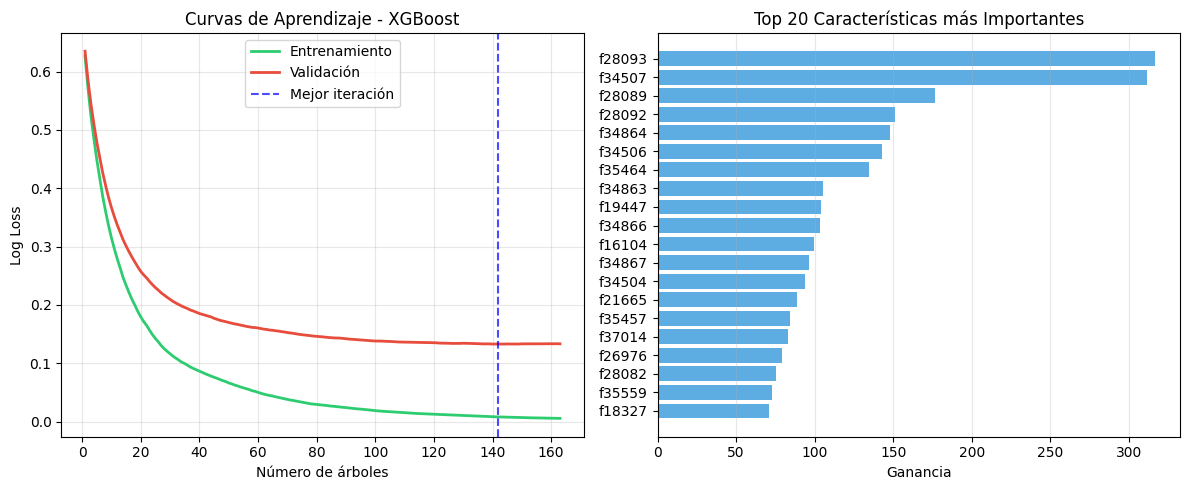

In [9]:
# Visualizar curvas de aprendizaje
plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
epochs = range(1, len(evals_result['train']['mlogloss']) + 1)
plt.plot(epochs, evals_result['train']['mlogloss'], label='Entrenamiento', color='#2ecc71', linewidth=2)
plt.plot(epochs, evals_result['validation']['mlogloss'], label='Validación', color='#e74c3c', linewidth=2)
plt.axvline(x=xgb_model.best_iteration, color='blue', linestyle='--', alpha=0.7, label='Mejor iteración')
plt.xlabel('Número de árboles')
plt.ylabel('Log Loss')
plt.title('Curvas de Aprendizaje - XGBoost')
plt.legend()
plt.grid(alpha=0.3)

# Importancia de características (top 20)
plt.subplot(1, 2, 2)
importance_dict = xgb_model.get_score(importance_type='gain')
importance_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]
features = [item[0] for item in importance_items]
scores = [item[1] for item in importance_items]

plt.barh(range(len(features)), scores, color='#3498db', alpha=0.8)
plt.yticks(range(len(features)), features)
plt.xlabel('Ganancia')
plt.title('Top 20 Características más Importantes')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Realizar predicciones en el conjunto de validación
y_val_pred_proba = xgb_model.predict(dval)
y_val_pred = np.argmax(y_val_pred_proba, axis=1)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("\n=== RESULTADOS EN CONJUNTO DE VALIDACIÓN ===")
print(f"\nAccuracy: {val_accuracy:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_val, y_val_pred, target_names=CLASSES))


=== RESULTADOS EN CONJUNTO DE VALIDACIÓN ===

Accuracy: 0.9542

Reporte de Clasificación:
               precision    recall  f1-score   support

kidney_normal       0.98      0.93      0.95      1200
 kidney_tumor       0.93      0.98      0.96      1200

     accuracy                           0.95      2400
    macro avg       0.96      0.95      0.95      2400
 weighted avg       0.96      0.95      0.95      2400



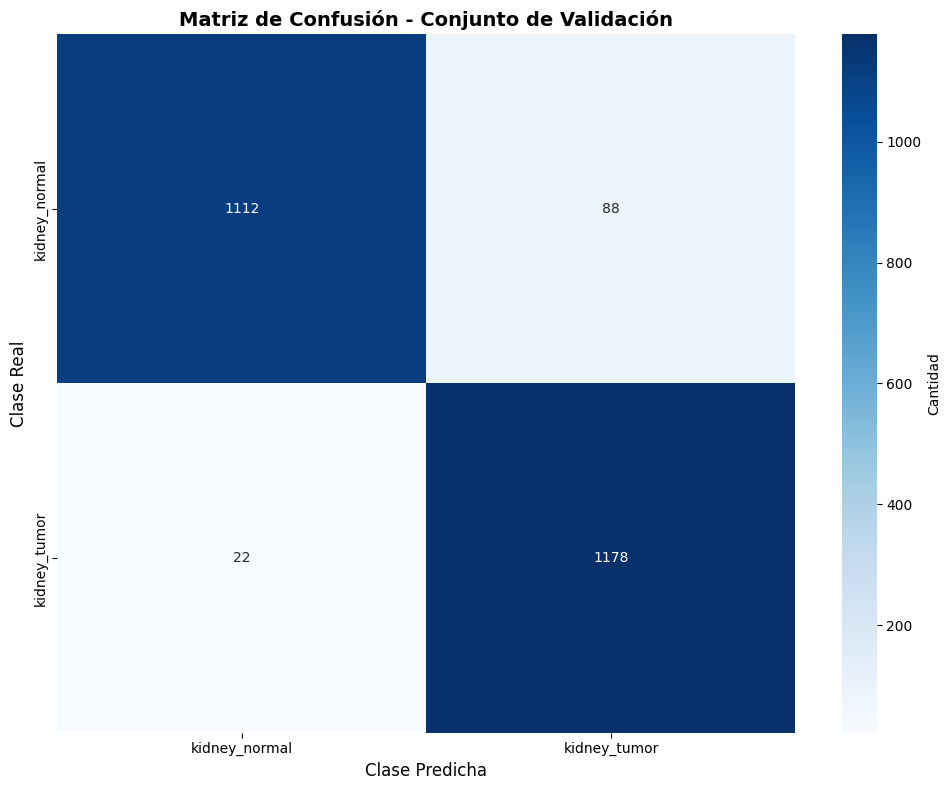

In [11]:
# Matriz de confusión - Validación
cm_val = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión - Conjunto de Validación', fontsize=14, fontweight='bold')
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.show()

In [12]:
# Evaluar en el conjunto de prueba
y_test_pred_proba = xgb_model.predict(dtest)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("\n=== RESULTADOS EN CONJUNTO DE PRUEBA ===")
print(f"\nAccuracy: {test_accuracy:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_test_pred, target_names=CLASSES))


=== RESULTADOS EN CONJUNTO DE PRUEBA ===

Accuracy: 0.9525

Reporte de Clasificación:
               precision    recall  f1-score   support

kidney_normal       0.97      0.93      0.95      1200
 kidney_tumor       0.93      0.97      0.95      1200

     accuracy                           0.95      2400
    macro avg       0.95      0.95      0.95      2400
 weighted avg       0.95      0.95      0.95      2400



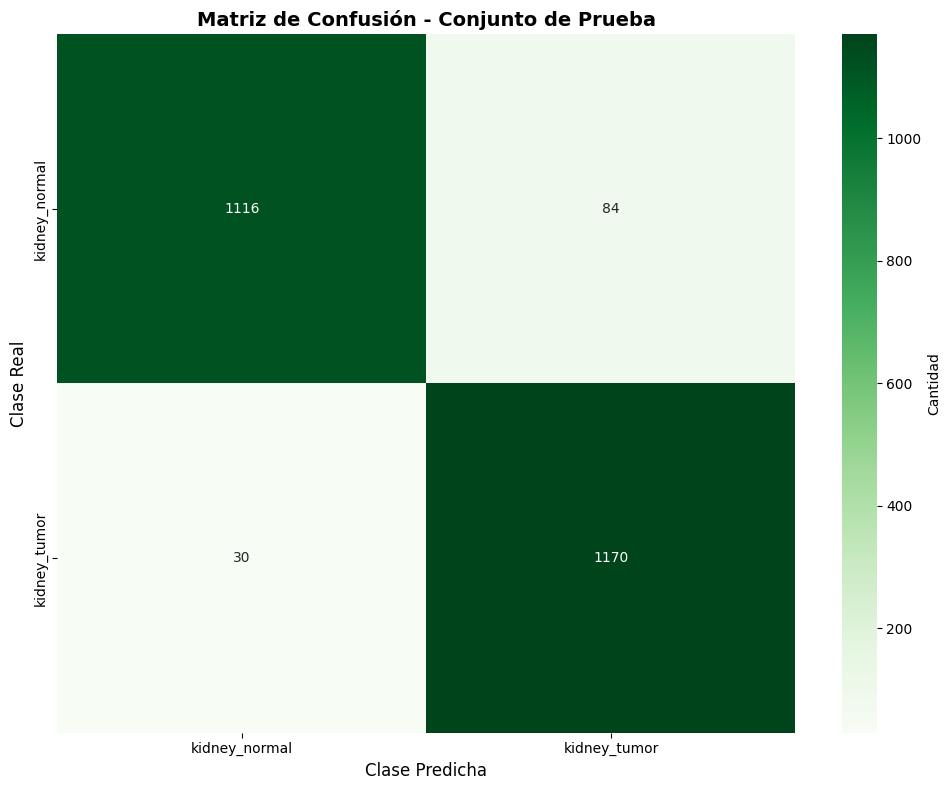

In [13]:
# Matriz de confusión - Prueba
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar_kws={'label': 'Cantidad'})
plt.title('Matriz de Confusión - Conjunto de Prueba', fontsize=14, fontweight='bold')
plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.show()

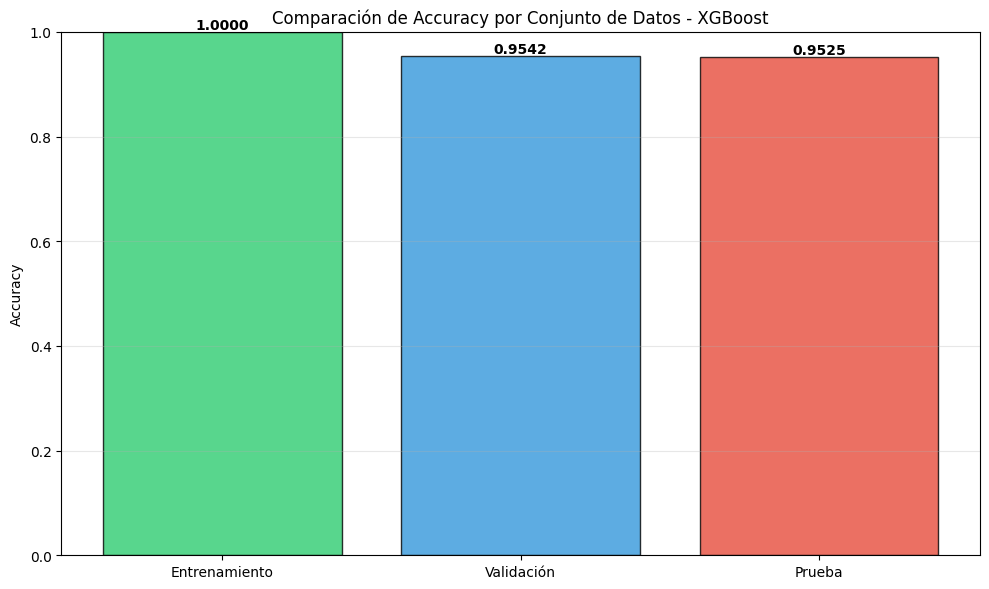


Accuracy Entrenamiento: 1.0000
Accuracy Validación: 0.9542
Accuracy Prueba: 0.9525


In [14]:
# Comparar accuracy entre conjuntos
train_pred_proba = xgb_model.predict(dtrain)
train_pred = np.argmax(train_pred_proba, axis=1)
train_accuracy = accuracy_score(y_train, train_pred)

plt.figure(figsize=(10, 6))
accuracies = [train_accuracy, val_accuracy, test_accuracy]
labels = ['Entrenamiento', 'Validación', 'Prueba']
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = plt.bar(labels, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy por Conjunto de Datos - XGBoost')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.4f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nAccuracy Entrenamiento: {train_accuracy:.4f}")
print(f"Accuracy Validación: {val_accuracy:.4f}")
print(f"Accuracy Prueba: {test_accuracy:.4f}")

In [15]:
# Guardar el modelo entrenado
model_path = 'models/xgboost_model.json'
xgb_model.save_model(model_path)
print(f"Modelo guardado en: {model_path}")

Modelo guardado en: models/xgboost_model.json


In [16]:
# Función para predecir una nueva imagen
def predecir_imagen(ruta_imagen, modelo, img_size, classes):
    """
    Predice la clase de una imagen usando el modelo XGBoost entrenado.
    
    Args:
        ruta_imagen: Ruta de la imagen a predecir
        modelo: Modelo XGBoost entrenado
        img_size: Tamaño al que redimensionar la imagen
        classes: Lista de nombres de clases
    
    Returns:
        Índice de la clase predicha
    """
    # Cargar y preprocesar imagen
    img = Image.open(ruta_imagen).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img, dtype=np.float32).flatten() / 255.0
    img_array = img_array.reshape(1, -1)
    
    # Crear DMatrix para XGBoost
    dimg = xgb.DMatrix(img_array)
    
    # Realizar predicción
    probabilidades = modelo.predict(dimg)[0]
    prediccion = np.argmax(probabilidades)
    
    # Mostrar resultados
    print(f"Clase predicha: {classes[prediccion]}")
    print("\nProbabilidades por clase:")
    for i, prob in enumerate(probabilidades):
        print(f"  {classes[i]}: {prob:.4f}")
    
    # Mostrar imagen
    plt.figure(figsize=(6, 6))
    plt.imshow(Image.open(ruta_imagen))
    plt.title(f"Predicción: {classes[prediccion]} ({probabilidades[prediccion]:.2%})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return prediccion

# Ejemplo de uso:
# predecir_imagen('ruta/a/tu/imagen.jpg', xgb_model, IMG_SIZE, CLASSES)

In [17]:
# Función para cargar un modelo previamente guardado
def cargar_modelo(model_path):
    """
    Carga un modelo XGBoost desde un archivo.
    
    Args:
        model_path: Ruta del archivo del modelo
    
    Returns:
        Modelo XGBoost cargado
    """
    modelo = xgb.Booster()
    modelo.load_model(model_path)
    print(f"Modelo cargado desde: {model_path}")
    return modelo

# Ejemplo de uso:
# modelo_cargado = cargar_modelo('xgboost_model.json')
# predecir_imagen('ruta/imagen.jpg', modelo_cargado, IMG_SIZE, CLASSES)